# Tutorial 3: Classification using simple statistics
## Part a:  Using thresholds ##

#### Welcome to the next-to-last tutorial

This tutorial will show you how to use python code to implement and evaluate a classification method applied to a dataset (namely, our rooibos data). Current classification methods can be categorized as either (1) basic statistical methods; (2) machine learning; or (3) deep learning. In this notebook, we will use two classical statistical methods: thresholding and  Mahalanobis distance (a mathematical concept invented by the Indian statistician P.C. Mahalanobis in 1936).

Besides using the classification methods, it is also important to evaluate the performance of each method. In many cases, one of the two classes is of particular interest. In such cases there is a tradeoff between positively identifying all instances of this class, and avoiding positives. This tradeoff is expressed in terms of two important concepts (which are explained below):  _recall_ and _precision_. 

When the two classes are equally important, the overall classification accuracy is often used as a measure of performance. As with any parameter estimation, it is important to put error bars on accuracy estimates. For this purpose, we will introduce the "jackknife" method for estimating standard deviations of estimators.  As its name suggests, the jackknife method is a very useful general-purpose tool which can be applied to a wide variety of estimators.  

---

### Overview of the classification problem  in general

The following picture demonstrates the simple idea behind computational classification of objects. The general procedure is:
* Extract features from data;
* Pass the features into a model;
* The model outputs a determination of the sample's class.

<img src="pics/cat.png" width="700" height="300">

In this tutorial we are classifying tea samples, and the  features we will be using are the TPC, TEAC, and FRAP measurements obtained from chemical assays.

To make this work, the analyst must:
* Determine informative features to be used;
* Develop a model that can effectively make use of the features extracted;
* Evaluate the accuracy of the overall system


### Binary classification errors: false positives and false negatives

Binary classification supposes that we are trying to distinguish between two classes, denoted as "null" and "positive". In this case when distinguishing there are two possible errors: false positive or false negative:
  * **[False positive](https://www.statisticshowto.com/false-positive-definition-and-examples/)**: This is where you receive a positive result for a test, when you should have received a negative (null) result. For example, it occurs when a cancer screening test comes back positive, but you don’t have the disease.
  * **[False negative](https://www.statisticshowto.com/false-positive-definition-and-examples/)**: This is where a negative (null) test result is wrong. For example, in the Justice System, a false negative occurs when a guilty suspect is found “not guilty” and allowed to walk free.
  
Based on these definitions, we may define:

   * _False positive rate_: What proportion of positive identifications were actually negatives?
   * _False negative rate_: What proportion of negative identifications were actually positive?

These two work against each other: decreasing the false positive rate tends to increase the false negative rate.


* False positive rate is related to [specificity  and precision](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall)
* False negative rate is related to [recall and sensitivity](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall)

We will define precision and recall below. Of the four measures mentioned, these are the two that are most often used.

### Classification by threshold, and measures of performance

Often binary classification is based on a single feature (or measurement), or a single quantity calculated from the features of the data sample. If this quantity exceeds a threshold (which is set by the programmer) then the sample is judged to be in one class, and if not the sample is put in the other class.

The following [figure](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) shows 30 predictions made by an email classification model. Those to the right of the classification _threshold_ are classified as "spam", while those to the left are classified as "not spam."

<img src="pics/preVSrec.svg" width="700" height="200">

where the results can be summaried as follows:

<img src="pics/table.png" width="300" height="150">


From these we may calculate:

* _Precision_ (specificity) measures the percentage of **emails flagged as spam** that were correctly classified—that is, the proportion of all dots to the right of the threshold line that are green in the above figure.
<img src="pics/pre.png" width="350" height="150">
* _Recall_ (sensitivity)  measures the percentage of **actual spam emails** that were correctly classified—that is, the proportion of all green dots that are to the right of the threshold line in the above figure.
<img src="pics/rec.png" width="330" height="160">
* _Accuracy_ gives the overall percentage of correct classifications, and can be calculated  as follows: <br><br>
<img src="pics/acc.png" width="550" height="270">

Different thresholds will give different values for these three measures. 

---

[**Exercise 1:**](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall) Consider a classification model that separates email into two categories: "spam" or "not spam." If you raise the classification threshold, what will happen to precision? What about recall?



_Answer here_


### Representing threshold performance tradeoffs  with receiver operating characteristic [(ROC)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) curves

Receiver operating characteristic (ROC) curves are used to determine thresholds based on the trade-off between false positive error and false negative error. The ROC curve actually shows something slightly different--it represents the proportion of negatives that are _incorrectly_ classified on the x axis versus the proportion of positives that are _correctly_ classified on the y-axis. 

Our example will use code the python packages matplotlib, numpy, and sklearn. We will also make use of some pre-written programs that are located in the `source` directory--these will be imported later.



In [26]:
# ___Cell no. 1___

# Python packages 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

### Exercise 1

1. Using the ```store``` command, recover the dataframes ```df_nf, df_fer,``` and ```df```.  
2. Display the number of rows and columns of ```df```
3. Display the first two lines of ```df```.

In [27]:
# ___Cell no. 2___

### Put your code here
%store -r df
%store -r df_nf
%store -r df_fer

display (df.head(2))
display(df_nf.head(2))
display(df_fer.head(2))


,type,TPC_H2O,TEAC_H2O,FRAP_H2O,TPC_MEOH,TEAC_MEOH,FRAP_MEOH,cut
0,1,457.982012,3791.630281,1053.209972,257.631541,2063.016672,829.673865,RS
1,1,339.713588,2825.660880,627.777353,266.472210,2103.093927,627.469976,RS


,type,TPC_MEOH,TEAC_MEOH,FRAP_MEOH,TPC_H2O,TEAC_H2O,FRAP_H2O,cut
0,0,275.767474,2821.888864,1180.778887,314.33,2588.61,584.61,FC
1,0,253.494375,2355.706326,647.096605,331.41,2818.87,589.91,LL


,type,TPC_H2O,TEAC_H2O,FRAP_H2O,TPC_MEOH,TEAC_MEOH,FRAP_MEOH,cut
0,1,457.982012,3791.630281,1053.209972,257.631541,2063.016672,829.673865,RS
1,1,339.713588,2825.660880,627.777353,266.472210,2103.093927,627.469976,RS


Now let's create arrays for the inputs and outputs. We will separately identify water-based and methanol-based features.

In [28]:
# ___Cell no. 3___

feat_H2O = ['TPC_H2O', 'TEAC_H2O',  'FRAP_H2O'] # define the input (features) for H20
feat_MEOH = ['TPC_MEOH', 'TEAC_MEOH',  'FRAP_MEOH'] # define the input (features) for MeOH

y = df[['type']] # define the output (target)

We consider the case where we are trying to use individual features to distinguish between fermented and nonfermented.  Since we have three different features, for each feature we can set a classification threshold.  The question is:  of these three features, which will give better classification results? We may use the ROC curves associated with each feature to determine this.

We may draw the ROC curves by sorting the data (together with its classification) and counting:

#### Exercise 2
Complete the incomplete portions of the following code according to the comments (marked with a @@@)

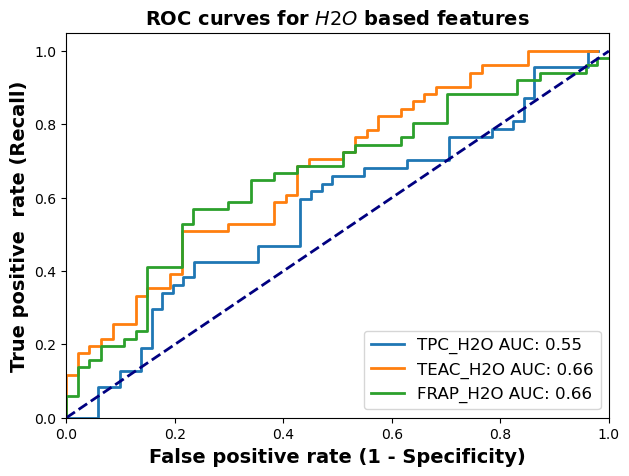

In [29]:
# ___Cell no. 4___

## Generate ROC curves for different features

thrPos =[False,True,True]# Test direction for the different features tested 
# True = above threshold is taken as positive, 
# False = above threshold is taken as negative

plt.figure(figsize=(7 , 5))# Set size of plot figure

for f, thp in zip(feat_H2O, thrPos):# Loop through features and threshold directions

    xArr = np.array(df[[f]]).flatten()# Create 1d array of feature
    nx = len(xArr)# Number of data elements
    
    yArr = np.array(y).flatten()# Create 1d array of output
    
    # Flip pos/neg labels if negatives are above threshold
    if not(thp):
        yArr = 1-yArr
    
    # Sort the values in increasing order
    ix = np.argsort(xArr)
    # Sort the corresponding type determination
    ySort= yArr[ix]
    
    # Running count of number of positives below threshold
    FN = np.cumsum(ySort)
    # Running count of number of negatives below threshold
    TN = np.cumsum(1-ySort)
    # Running count of number of positives above threshold
    TP  = np.sum(ySort)-FN # Complete this using the above formulas
    # Running count of number of negatives above threshold
    FP  = np.sum(1-ySort)-TN # Complete this using the above formulas
    # Proportion of positives that are above the threshold
    TPR = TP/(TP+FN)
    # Propostion of negatives that are above the threshold
    FPR = FP/(TN+FP) # Complete this
    # Plot FPR (x-axis) versus TPR (y-axis)
    plt.plot(FPR,TPR, lw=2, label = f+" AUC: "+str(round(metrics.auc(FPR, TPR),2)) )

# Plot 45 degree line ('guessing')    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# Set x and y limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# label x and y axes
plt.xlabel('False positive rate (1 - Specificity)', fontweight ='bold', fontsize =14)
plt.ylabel('True positive  rate (Recall)', fontweight ='bold', fontsize =14)
# title and legend
plt.title('ROC curves for $H2O$ based features', fontweight ='bold', fontsize =14)
plt.legend(loc="lower right", prop={"size":12})
plt.show() 






**Exercise 3:** Copy and change the above code so that all ROC curves lie above the dotted line.
<br>


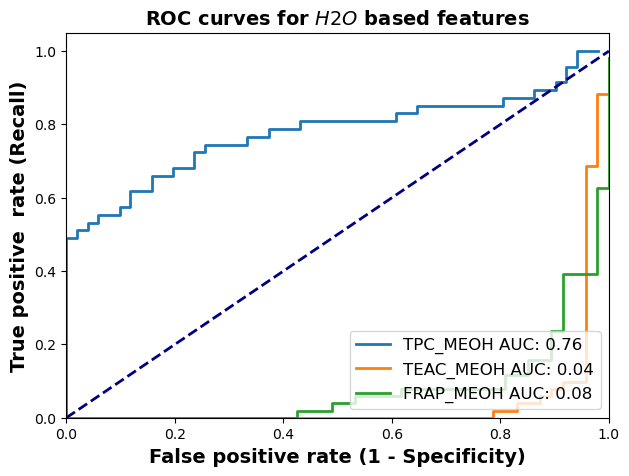

In [30]:
# ___Cell no. 4___

#  ___ code here ____

## Generate ROC curves for different features

thrPos =[False,True,True]# Test direction for the different features tested 
# True = above threshold is taken as positive, 
# False = above threshold is taken as negative

plt.figure(figsize=(7 , 5))# Set size of plot figure

for f, thp in zip(feat_MEOH, thrPos):# Loop through features and threshold directions

    xArr = np.array(df[[f]]).flatten()# Create 1d array of feature
    nx = len(xArr)# Number of data elements
    
    yArr = np.array(y).flatten()# Create 1d array of output
    
    # Flip pos/neg labels if negatives are above threshold
    if not(thp):
        yArr = 1-yArr
    
    # Sort the values in increasing order
    ix = np.argsort(xArr)
    # Sort the corresponding type determination
    ySort= yArr[ix]
    
    # Running count of number of positives below threshold
    FN = np.cumsum(ySort)
    # Running count of number of negatives below threshold
    TN = np.cumsum(1-ySort)
    # Running count of number of positives above threshold
    TP  = np.sum(ySort)-FN # Complete this using the above formulas
    # Running count of number of negatives above threshold
    FP  = np.sum(1-ySort)-TN # Complete this using the above formulas
    # Proportion of positives that are above the threshold
    TPR = TP/(TP+FN)
    # Propostion of negatives that are above the threshold
    FPR = FP/(TN+FP) # Complete this
    # Plot FPR (x-axis) versus TPR (y-axis)
    plt.plot(FPR,TPR, lw=2, label = f+" AUC: "+str(round(metrics.auc(FPR, TPR),2)) )

# Plot 45 degree line ('guessing')    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# Set x and y limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# label x and y axes
plt.xlabel('False positive rate (1 - Specificity)', fontweight ='bold', fontsize =14)
plt.ylabel('True positive  rate (Recall)', fontweight ='bold', fontsize =14)
# title and legend
plt.title('ROC curves for $H2O$ based features', fontweight ='bold', fontsize =14)
plt.legend(loc="lower right", prop={"size":12})
plt.show() 







---
**Exercise 4:** Make another graph for the three features based on MeOH. Make sure that all curves are above the dotted line.
<br>


In [31]:
# ___Cell no. 5___

#  ___ code here ____



The ROC curve does not actually tell you which threshold to use. Rather, it only tells you what true positive/false positive tradeoffs are possible.  The user will have to decide which tradeoff is most suitable for his situation, and set the threshold accordingly. 

ROC curves are especially useful if you want to compare different classifiers. Classifiers with higher ROC curves are better than classifiers with lower curves.


---
**Exercise 5:** Use the AUC's obtained frm ROC curves to determine which of the 6 individual measurements gives the best classifier.

### Classification using multiple thresholds

Suppose now that you want to distinguish fermented and unfermented samples based one two variables. One way to do this is set a threshold for each variable, and classify each sample based on the size of the two variables relative to the threshold. For example, if you use `TP_MEOH` and `TEAC_MEOH` and the threshold values are 350 for `TPC_MEOH` and 2250 for `TEAC_MEOH`, then the two thresholds divide the plane into four quadrants, and we can classify each sample as fermented or unfermented depending on which quadrant it lies in.


**Exercise 6**


a. Make a copy of the plot that you constructed in Exercise 2 in Tutorial 2. Using the threshold values 350 for `TPC_MEOH` and 2250 for `TEAC_MEOH`, draw the four quadrants produced by the two thresholds. Which sample type would be best to assign to each quadrant?

b. We may investigate which pair of thresholds will give the best performance.  Write a program that does the following: 

  - Loop through 50 evenly-spaced thresholds for TPC and 50 evenly-spaced thresholds for TEAC
  - For each of the 2500 threshold pair, compute the accuracy of a classifier based on that pair of thresholds
  - Store your accuracies in a $50 \times 50$ matrix
  - Do a contour plot that displays accuracy as a function of the two thresholds. Do also a heatmap  that displays the same information. Decide which of the two is most informative, and justify your decision (you can write your justification as a comment at the beginning of the program.
   - Locate a pair of thresholds that gives the best accuracy. On the plot that you choose, draw the two thresholds as horizontal and vertical lines.
   - Superimpose the two sets of data points on your plot (scatter plot).
   - Your program should also output the accuracy obtained by the best pair of thresholds
   
c. Modify your program from (b) to calculate the precision and recall, which are defined above. Redo the contour plot (or heatmap) to show the precision, and also a separate plot to show the recall.

d. On the basis of (c) above, explain why precision and recall alone are insufficient to determine a best estimator.



In [32]:
# ___Cell no. 6___

# Code here #